<a href="https://colab.research.google.com/github/shawkoike/colab/blob/main/%E3%83%90%E3%82%B9%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### バスモデルとは

新製品の潜在購入者を「自らの意思のみで購入する人」と「新製品の普及状況をみながら購入の意思決定をする人」によって構成される。

つまり,     
「t期にある製品を購入する人数」は「t-1期までにすでに購入した人の影響を受けずに購入する人」と「t-1期までにすでに購入した人の影響を受けて購入する人」の和として表現される。

$$
n_t = p(m - N_{t-1}) + q \dfrac{N_{t-1}}{m}(m - N_{t-1})
$$

- n(t)：t期の購入者数
- N(t)：t期までの累積購入者数
- m：潜在市場規模
- p：既存の購入者とは独立な影響を表すパラメータ
- q：既存購買者の影響を表すパラメータ

右辺の前半部分が「t-1期までに既に購入した人の影響を受けずに購入する人」     
後半部分が「t-1期までに既に購入した人の影響を受けて購入する人」

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from math import sqrt

In [6]:
df = pd.read_csv("drive/MyDrive/Colab Notebooks/recipe/data/sample_data.csv")
df.head()

,時点,Quantity,Total_Quantity,Last_Total_Quantity,Last_Total_Quantity_sq
0,1,4998,4998,0,0
1,2,5398,10396,4998,24980004
2,3,5611,16007,10396,108076816
3,4,5574,21581,16007,256224049
4,5,5292,26873,21581,465739561


Text(0.5, 1.0, 'Quantity')

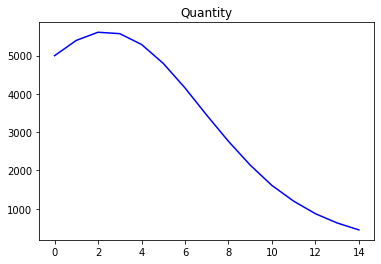

In [7]:
# 「購入者」を可視化
df["Quantity"].plot(style="blue")
plt.title("Quantity")

Text(0.5, 1.0, 'Total Quantity')

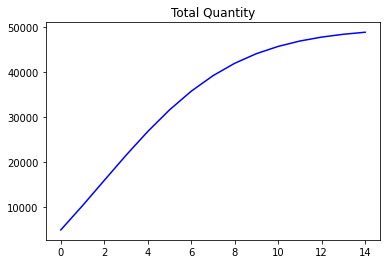

In [9]:
# 「累積購入者数」を可視化
df["Total_Quantity"].plot(style="blue")
plt.title("Total Quantity")

### 回帰モデルの導入

バスモデルの指揮を展開すると以下のようになる

$$
pm + (q - p)N_{t-1} - \dfrac{q}{m}N^2_{t-1}
$$

ここで a = pm, b = (q-p), c = q/m とすると

$$
n_t = a + bN_{t-1} - cN^2_{t-1}
$$

となり、パラメータに関して線形な重回帰モデルとみなすことができる。
よって、回帰パラメータによって a. b, c を推定する。

バズモデルでは、説明変数を「一期前の時点における累積購入者数」と「一期前の時点における累積購入者数の二乗」とし、目的変数を「購入変数」とすることで重回帰モデルの構築を行っていく。

In [11]:
# 回帰用の新しいデータフレームを作成
linRegData = pd.DataFrame()
linRegData["Quantity"] = df["Quantity"]
linRegData["N"] = df["Last_Total_Quantity"]
linRegData["N**2"] = df["Last_Total_Quantity_sq"]
linRegData

,Quantity,N,N**2
0,4998,0,0
1,5398,4998,24980004
2,5611,10396,108076816
3,5574,16007,256224049
4,5292,21581,465739561
5,4798,26873,722158129
6,4157,31671,1003052241
7,3445,35828,1283645584
8,2762,39273,1542368529
9,2141,42035,1766941225


In [13]:
# 回帰分析
linearRegression = linear_model.LinearRegression()
linearRegression.fit(linRegData[["N", "N**2"]].values, linRegData["Quantity"].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
linearRegression.intercept_, linearRegression.coef_

(4999.170101054309, array([ 9.99415961e-02, -3.99701729e-06]))

In [17]:
import statsmodels.api as sm

regX_axis = sm.add_constant(linRegData[["N", "N**2"]].values, prepend=False)
regY_axis = linRegData["Quantity"].values

ols_regression = sm.OLS(regY_axis, regX_axis).fit()
ols_regression.summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.156e+06
Date:                Thu, 11 Nov 2021   Prob (F-statistic):           4.73e-35
Time:                        01:59:55   Log-Likelihood:                -35.823
No. Observations:                  15   AIC:                             77.65
Df Residuals:                      12   BIC:                             79.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0999      0.000    489.525      0.000       0.099       0.100
x2         -3.997e-06   3.81e-09  -1049.849      0.000   -4.01e-06   -3.99e-06
const       4999.1701      2.249   2222.766      0.000    4994.270    5004.070
==============================================================================
Omnibus:                        0.044   Durbin-Watson:                   2.873
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.267
Skew:                          -0.048   Prob(JB):                        0.875
Kurtosis:                       2.353   Cond. No.                     4.37e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.37e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### バスモデルの導入

上記の回帰モデルで求めた切片と偏回帰係数を用いて、バスモデルを導出していく。

In [18]:
# T = 推定区間
T = 14
a = linearRegression.intercept_
b = linearRegression.coef_[0]
c = linearRegression.coef_[1]
a, b, c

(4999.170101054309, 0.09994159608950114, -3.99701728678897e-06)

In [20]:
# m を求める（解と係数の関係）
m = (-b - sqrt(b ** 2-(4 * a * c))) / (2 * c)
m

50012.36347728622

In [21]:
# a, b, c を用いてパラメータ p, q を推定
p = a / m
q = p + b

p, q

(0.0999586852823852, 0.19990028137188634)

In [25]:
# 購入者数予測と累積購入者数予測を行っていく
predictionQt2 = [0,]
predictionN2 = [0,]

for i in range(0, T):
  N = predictionN2[i]
  adoptationT = (p*m)+(q-p)*N + (-q/m) * N**2
  adoptationT = round(adoptationT, 2)
  predictionQt2.append(adoptationT)
  predictionN2.append((predictionN2[i]+adoptationT))

In [26]:
bass_df = pd.DataFrame()
bass_df["Prediction_Quantity"] = predictionQt2
bass_df["Prediction_Total_Quantity"] = predictionN2

df = bass_df.join(df, on=None, how="left")

In [27]:
df

,Prediction_Quantity,Prediction_Total_Quantity,時点,Quantity,Total_Quantity,Last_Total_Quantity,Last_Total_Quantity_sq
0,0.00,0.00,1,4998,4998,0,0
1,4999.17,4999.17,2,5398,10396,4998,24980004
2,5398.90,10398.07,3,5611,16007,10396,108076816
3,5606.21,16004.28,4,5574,21581,16007,256224049
4,5574.88,21579.16,5,5292,26873,21581,465739561
5,5294.57,26873.73,6,4798,31671,26873,722158129
6,4798.34,31672.07,7,4157,35828,31671,1003052241
7,4155.04,35827.11,8,3445,39273,35828,1283645584
8,3449.29,39276.40,9,2762,42035,39273,1542368529
9,2758.58,42034.98,10,2141,44176,42035,1766941225


### 評価

<Figure size 432x288 with 0 Axes>

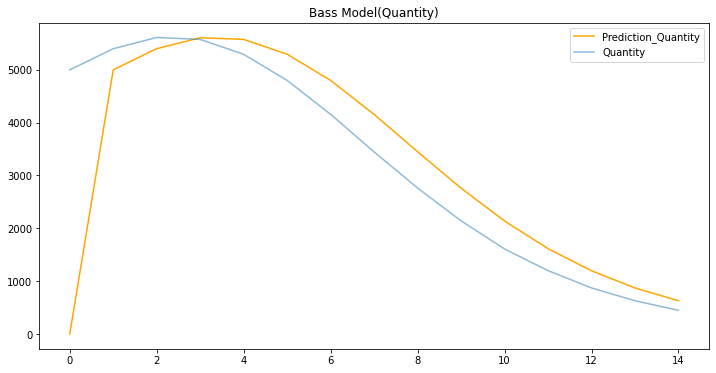

<Figure size 432x288 with 0 Axes>

In [32]:
# 購入者数予測
plt.figure(figsize=(12, 6))
df["Prediction_Quantity"].plot(color="orange")
df["Quantity"].plot(alpha=0.5)
plt.title("Bass Model(Quantity)")
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

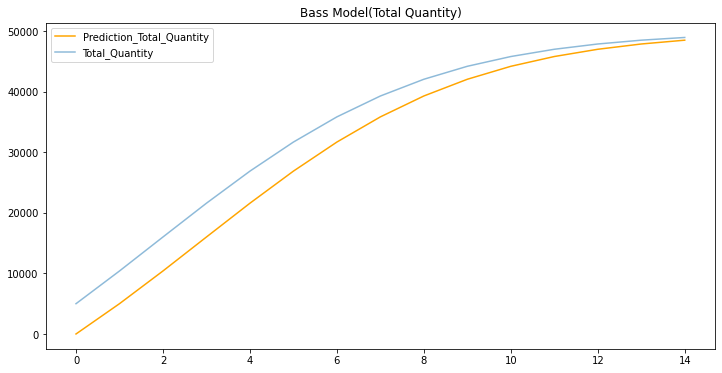

<Figure size 432x288 with 0 Axes>

In [34]:
# 普及プロセス
plt.figure(figsize = (12, 6))
df["Prediction_Total_Quantity"].plot(color="orange")
df["Total_Quantity"].plot(alpha=0.5)
plt.title("Bass Model(Total Quantity)")
plt.legend()
plt.figure()

### 考察

- p = イノベーション係数     
- q = イミテーション係数     

と言い換えることができる。

今回の分析では q > p なのでイミテーション係数の方が大きい。

すなわちこのサンプル製品は既存購入者の影響が強く、緩やかに普及していると評価することができる。

逆に p > q の場合は、イノベーション係数の方が大きいので既存の購入者に影響されずに購入する人が多いことが推測でき、急速に普及すると考えられる。